In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import lfilter, freqz
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q librosa soundfile

In [3]:
filename = '/content/audio file.wav'


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.interpolate import interp1d
from scipy import signal
from IPython.display import Audio, display
import soundfile as sf

plt.rcParams['figure.figsize'] = (12,3)

def plot_waveform(t, x, title=''):
    plt.plot(t, x, linewidth=1)
    plt.title(title); plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.grid(True)
    plt.show()

def mse(a,b):
    return np.mean((a - b)**2)


(1) Implement sampling and quantization techniques for the given speech signals.

(a) Plot the time domain representation of the original speech signal.

File: /content/audio file.wav  Duration: 1.008s  SR: 48000 Hz


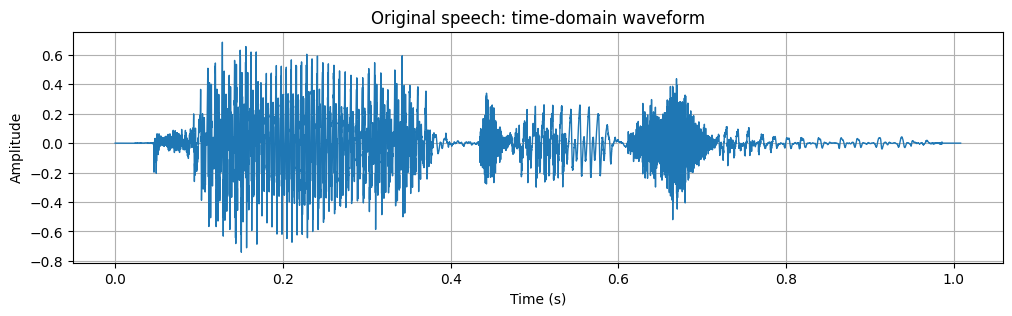

Playback original:


In [5]:
#  Load and plot original waveform playback
x_orig, sr_orig = librosa.load(filename, sr=None, mono=True)
duration = len(x_orig) / sr_orig
print(f'File: {filename}  Duration: {duration:.3f}s  SR: {sr_orig} Hz')

t_orig = np.arange(len(x_orig)) / sr_orig
plot_waveform(t_orig, x_orig, title='Original speech: time-domain waveform')

print("Playback original:")
display(Audio(x_orig, rate=sr_orig))


(b) and (c) Sample the speech signal at different sampling rates (e.g., 8kHz, 16kHz, and 44.1kHz).

In [6]:
#  Resample to target rates and show sample counts
target_srs = [8000, 16000, 44100]
sampled = {}
for fs in target_srs:
    x_samp = librosa.resample(x_orig, orig_sr=sr_orig, target_sr=fs)
    t_samp = np.arange(len(x_samp)) / fs
    sampled[fs] = (x_samp, t_samp)
    print(f'{fs} Hz -> {len(x_samp)} samples, duration {len(x_samp)/fs:.3f} s')


8000 Hz -> 8064 samples, duration 1.008 s
16000 Hz -> 16128 samples, duration 1.008 s
44100 Hz -> 44453 samples, duration 1.008 s


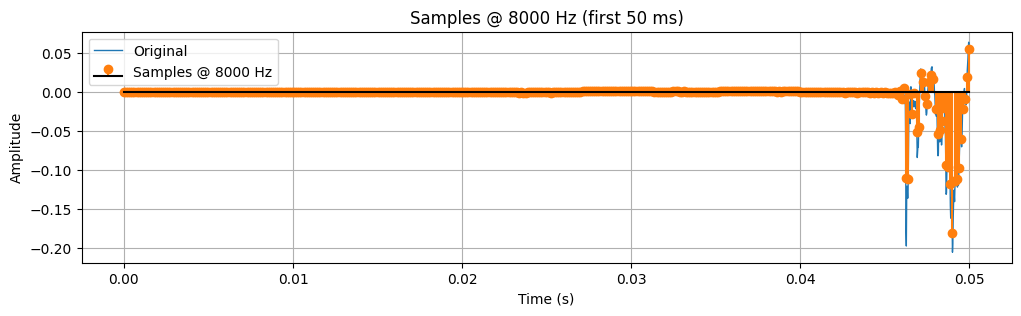

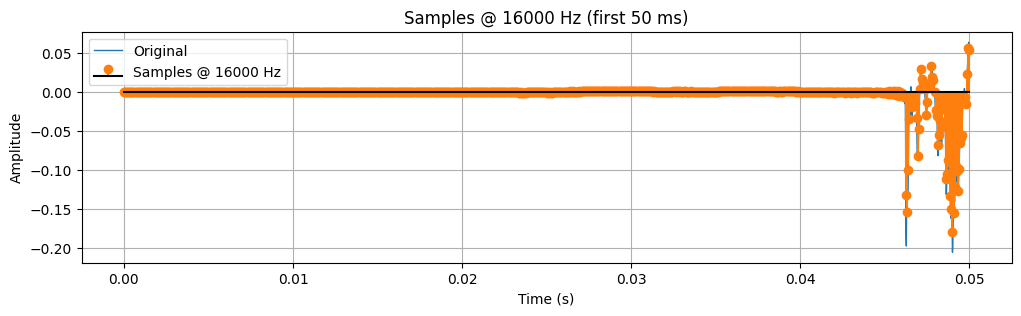

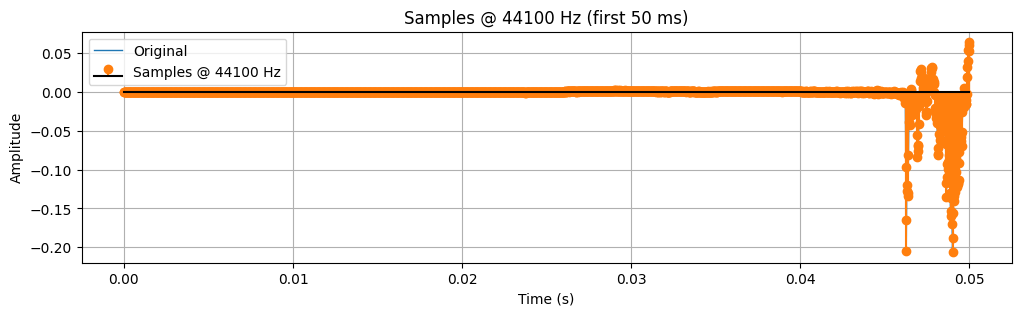

In [7]:
# Plot stem plots of samples overlayed on original for short zoom
zoom_end = 0.05
for fs in target_srs:
    x_samp, t_samp = sampled[fs]
    plt.figure(figsize=(12,3))
    idx_orig = t_orig <= zoom_end
    plt.plot(t_orig[idx_orig], x_orig[idx_orig], label='Original', linewidth=1)
    idx_s = t_samp <= zoom_end
    plt.stem(t_samp[idx_s], x_samp[idx_s], linefmt='C1-', markerfmt='C1o', basefmt='k-', label=f'Samples @ {fs} Hz')
    plt.title(f'Samples @ {fs} Hz (first {int(zoom_end*1000)} ms)')
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)
    plt.show()


Clearest Voice: 44,100 Hz. The graph shows the dots are very close together, capturing the most detail from the original sound wave. This means high fidelity.

Least Clear Voice: 8000 Hz. The graph shows the dots are far apart, missing a lot of detail. This results in a lower quality, muffled sound.

(d) Using the sampled signals from above, reconstruct the signal using:

(i) Zero-order hold (nearest-neighbor interpolation)

(ii) Linear interpolation.

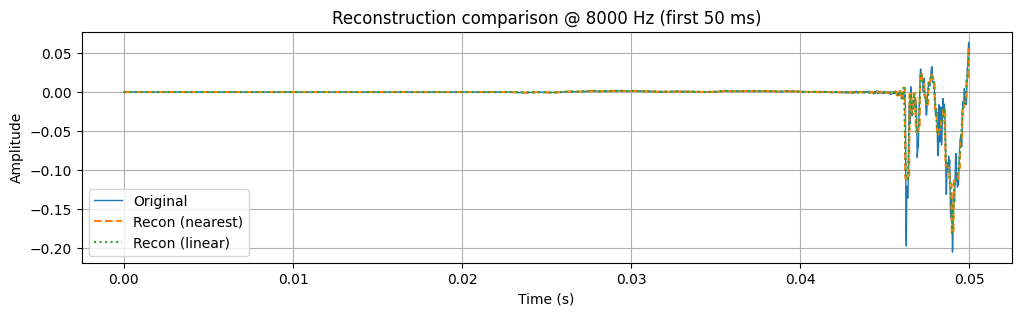

Playback reconstructed (linear) @ 8000 Hz -> resampled back to original SR for listening:


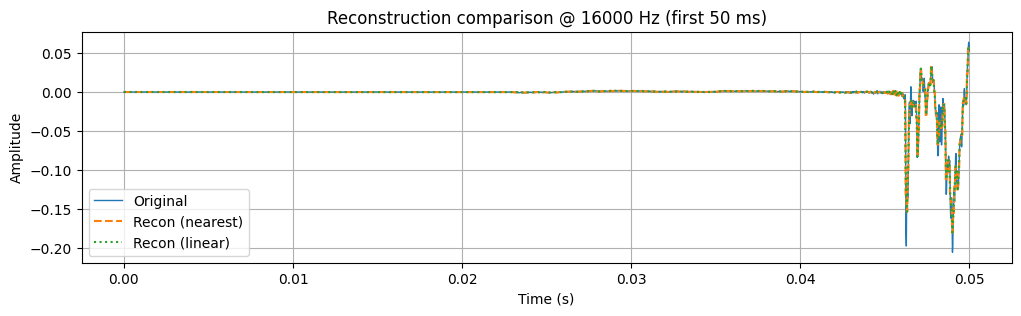

Playback reconstructed (linear) @ 16000 Hz -> resampled back to original SR for listening:


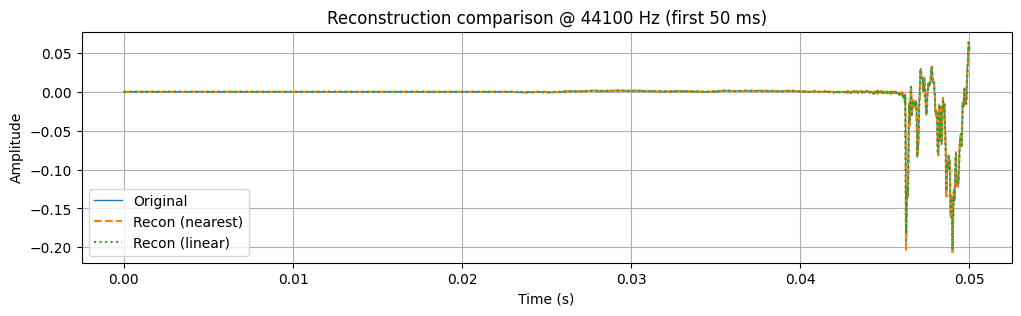

Playback reconstructed (linear) @ 44100 Hz -> resampled back to original SR for listening:


In [8]:
# Reconstruct onto original time grid using nearest and linear interpolation
reconstructions = {}
for fs in target_srs:
    x_samp, t_samp = sampled[fs]
    f_nearest = interp1d(t_samp, x_samp, kind='nearest', bounds_error=False, fill_value=(x_samp[0], x_samp[-1]))
    f_linear  = interp1d(t_samp, x_samp, kind='linear',  bounds_error=False, fill_value=(x_samp[0], x_samp[-1]))
    x_rec_nearest = f_nearest(t_orig)
    x_rec_linear  = f_linear(t_orig)
    reconstructions[fs] = (x_rec_nearest, x_rec_linear)

    # Zoomed plot
    idx_zoom = t_orig <= 0.05
    plt.figure(figsize=(12,3))
    plt.plot(t_orig[idx_zoom], x_orig[idx_zoom], label='Original', linewidth=1)
    plt.plot(t_orig[idx_zoom], x_rec_nearest[idx_zoom], label='Recon (nearest)', linestyle='--')
    plt.plot(t_orig[idx_zoom], x_rec_linear[idx_zoom],  label='Recon (linear)',  linestyle=':')
    plt.title(f'Reconstruction comparison @ {fs} Hz (first 50 ms)')
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True); plt.show()

    # Playback linear reconstruction
    print(f'Playback reconstructed (linear) @ {fs} Hz -> resampled back to original SR for listening:')
    display(Audio(x_rec_linear, rate=sr_orig))


Original (Solid Blue Line): This represents the true, high-quality audio from voice.wav file. It's the perfect signal that the other two lines are attempting to recreate.

Recon (nearest) (Dashed Orange Line): This is a simple reconstruction created using the Zero-Order Hold method. It fills in the gaps by holding the value of the last known sample, which results in a blocky, "staircase" approximation of the original signal.

Recon (linear) (Dotted Green Line): This is a more advanced reconstruction using Linear Interpolation. It "connects the dots" by drawing a straight line between two known samples to guess the values in between, resulting in a smoother and more accurate waveform.

(e) Calculate the Mean Squared Error (MSE) between the original and the reconstructed signals for both methods.

In [9]:
# Compute MSEs and print table
print("SamplingRate(Hz)   MSE_Nearest        MSE_Linear")
for fs in target_srs:
    x_rec_nearest, x_rec_linear = reconstructions[fs]
    m_nearest = mse(x_orig, x_rec_nearest)
    m_linear  = mse(x_orig, x_rec_linear)
    print(f"{fs:<16} {m_nearest: .6e}   {m_linear: .6e}")


SamplingRate(Hz)   MSE_Nearest        MSE_Linear
8000              1.614890e-03    9.556074e-04
16000             4.848786e-04    1.972687e-04
44100             6.912291e-05    3.973990e-06


8000Hz- The number 9.556074e-04 (which is 0.000955) is smaller than 1.614890e-03   (which is 0.001614).

16000Hz- The number 1.972687e-04 (which is 0.000197) is smaller than      4.848786e-04  (which is 0.000484).

44100Hz- The number 3.973990e-06 (which is 0.00000397) is much smaller than 6.912291e-05 (which is 0.0000691).

The error score for 44100 Hz is much smaller than the others. This is because a higher sampling rate captures far more detail from the original sound wave, allowing the reconstruction to be almost perfect. More samples mean fewer gaps to "guess," leading to a more faithful and clear audio output.

(2) Implement the source-filter model for a given speech signal and analyze the impact of sampling and reconstruction on the quality of the speech signal.

(a) Generate a synthetic speech signal using the source-filter model.

(i) Create a source signal (e.g., a glottal pulse train for voiced sounds or white noise for unvoiced sounds).

(ii) Apply a filter that models the vocal tract, represented by an all-pole filter or an FIR filter with formants (resonances of the vocal tract).

In [19]:
# Generate a synthetic speech signal using the source-filter model

# Parameters for synthesis
sr_synth = 44100      # Use a high sampling rate for good quality
duration = 1.0        # Generate 1 second of audio
F0 = 120.0            # Fundamental frequency (pitch) of 120 Hz
formants = [(700, 60), (1200, 90), (2600, 120)] # (Frequency, Bandwidth) for a vowel

# Create a time axis
t_synth = np.arange(int(sr_synth * duration)) / sr_synth

#  (i) Create the Source Signal (Glottal Pulse Train)
period = int(sr_synth / F0)
source_imp = np.zeros_like(t_synth)
source_imp[::period] = 1.0 # Place an impulse every period

# Smooth the impulses to make them more natural
win_len = int(0.002 * sr_synth)
win = np.hanning(win_len)
source_glottal = np.convolve(source_imp, win, mode='same')
print("Step (2a-i): Glottal source signal created.")

#  (ii) Create the Vocal Tract Filter
b_coeffs = np.array([1.0]) # Numerator for an all-pole filter is 1
a_coeffs = np.array([1.0]) # Start with the denominator

# Create second-order resonators for each formant and cascade them
for (Fk, Bk) in formants:
    r = exp(-pi * Bk / sr_synth)
    theta = 2 * pi * Fk / sr_synth
    a_k = np.array([1.0, -2.0 * r * cos(theta), r * r])
    a_coeffs = np.convolve(a_coeffs, a_k) # Cascade filters by convolving denominators
print("Step (2a-ii): All-pole vocal tract filter created.")

# Apply the filter to the source
synthetic_speech = lfilter(b_coeffs, a_coeffs, source_glottal)
# Normalize the final signal to a range of -1 to 1
synthetic_speech = synthetic_speech / np.max(np.abs(synthetic_speech))

print("\nSynthetic speech signal generated successfully!")
# You can listen to the generated sound
display(Audio(synthetic_speech, rate=sr_synth))

Step (2a-i): Glottal source signal created.
Step (2a-ii): All-pole vocal tract filter created.

Synthetic speech signal generated successfully!


(b) Plot the generated speech signal and analyze the effect of the filter on the original source.

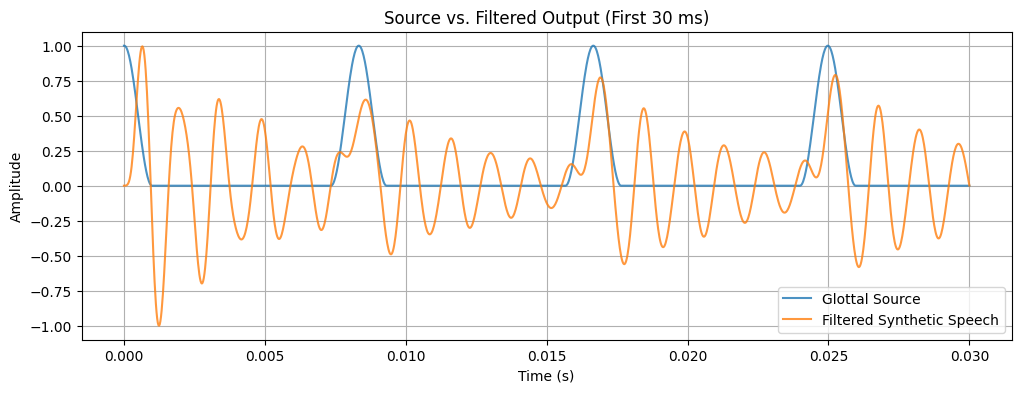

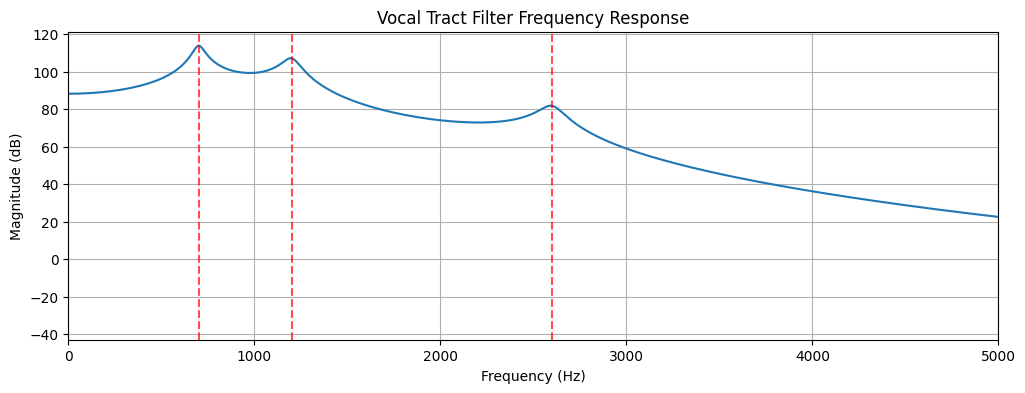

In [20]:
# Plot the generated speech signal and analyze the effect of the filter

plt.figure(figsize=(12, 4))
zoom_ms = 30
idx = t_synth <= (zoom_ms / 1000.0)
plt.plot(t_synth[idx], source_glottal[idx], label='Glottal Source', alpha=0.8)
plt.plot(t_synth[idx], synthetic_speech[idx], label='Filtered Synthetic Speech', alpha=0.8)
plt.title(f'Source vs. Filtered Output (First {zoom_ms} ms)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Filter's Frequency Response
w, h = freqz(b_coeffs, a_coeffs, worN=8000)
freq_axis_hz = (w / np.pi) * (sr_synth / 2)
plt.figure(figsize=(12, 4))
plt.plot(freq_axis_hz, 20 * np.log10(abs(h)))
for f, _ in formants: # Mark the formant locations
    plt.axvline(x=f, color='r', linestyle='--', alpha=0.7, label=f'Formant at {f} Hz')
plt.title('Vocal Tract Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 5000)
plt.grid(True)
plt.show()

Glottal Source (Blue Line): This represents the raw input from the simulated vocal cords. It's a simple, smooth, periodic pulse that provides the basic pitch of the voice. Think of it as a simple, repetitive "buzz."

Filtered Synth (Orange Line): This is the final output after the blue source signal has been passed through the vocal tract filter (which mimics the mouth and throat)

What it is: A blueprint of a simulated mouth and throat, showing which frequencies it will amplify.

The Peaks (Formants): These are the most important part. They are the specific frequencies that get boosted, and their pattern is what our brain recognizes as a particular vowel.

The Result: This filter turns a simple "buzz" from the vocal cords into a rich, vowel-like sound.

(c) Sample the speech signal generated above at different sampling rates (e.g., 8 kHz, 16 kHz, 44.1 kHz).

(d) Reconstruct the signal using a suitable interpolation method (e.g., zero-order hold, linear interpolation).


In [21]:
# Sample the speech signal generated above at different sampling rates

sampling_rates_synth = [8000, 16000, 44100]
sampled_signals_synth = {}

print("Sampling the synthetic speech signal...")
for fs_new in sampling_rates_synth:
    downsample_factor = int(sr_synth / fs_new)
    sampled_signal = synthetic_speech[::downsample_factor]
    sampled_signals_synth[fs_new] = sampled_signal
    print(f"Sampled at {fs_new/1000} kHz. Number of samples: {len(sampled_signal)}")

Sampling the synthetic speech signal...
Sampled at 8.0 kHz. Number of samples: 8820
Sampled at 16.0 kHz. Number of samples: 22050
Sampled at 44.1 kHz. Number of samples: 44100


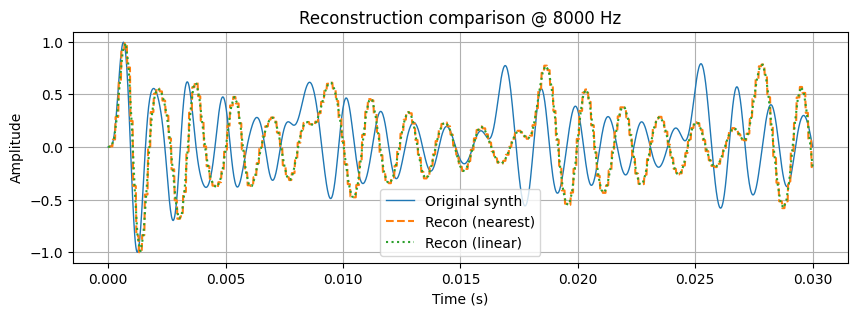

Playback: linear recon from 8000 Hz (reconstructed on original grid):


--------------------------------------------------


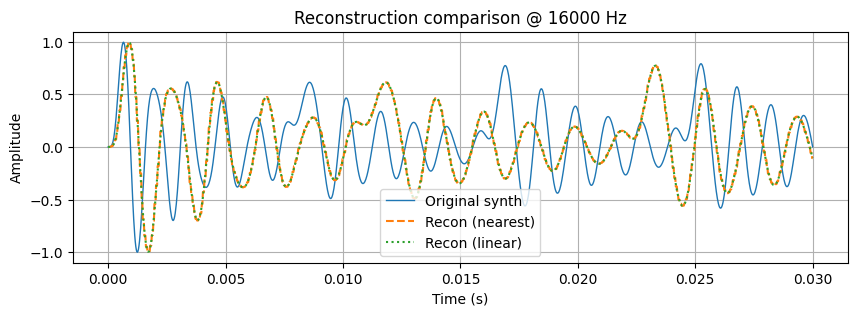

Playback: linear recon from 16000 Hz (reconstructed on original grid):


--------------------------------------------------


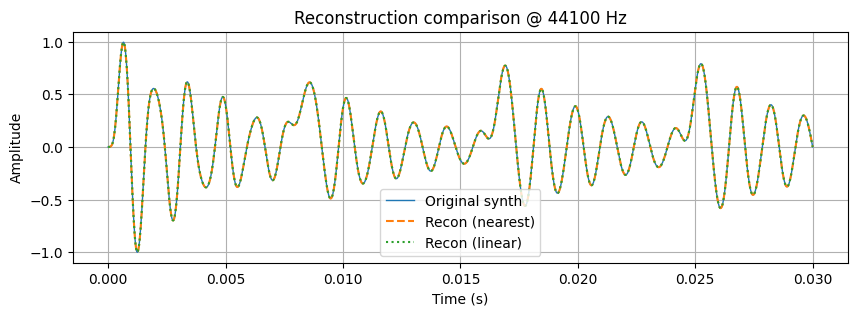

Playback: linear recon from 44100 Hz (reconstructed on original grid):


--------------------------------------------------


In [28]:
from scipy.interpolate import interp1d

reconstructions_synth = {}

for fs, sampled_sig in sampled_signals_synth.items():
    # Create the time axis for the current downsampled signal
    t_down = np.arange(len(sampled_sig)) / fs

    # Create the interpolation functions
    f_nearest = interp1d(t_down, sampled_sig, kind='nearest', bounds_error=False, fill_value=(sampled_sig[0], sampled_sig[-1]))
    f_linear  = interp1d(t_down, sampled_sig, kind='linear',  bounds_error=False, fill_value=(sampled_sig[0], sampled_sig[-1]))

    # Apply the functions to the original time grid to reconstruct
    rec_near = f_nearest(t_synth)
    rec_lin  = f_linear(t_synth)
    reconstructions_synth[fs] = (rec_near, rec_lin)

    # --- Plotting ---
    # Zoomed plot of original vs reconstructions (first 30 ms)
    idx = t_synth <= 0.03
    plt.figure(figsize=(10, 3))
    plt.plot(t_synth[idx], synthetic_speech[idx], label='Original synth', linewidth=1)
    plt.plot(t_synth[idx], rec_near[idx], label='Recon (nearest)', linestyle='--')
    plt.plot(t_synth[idx], rec_lin[idx], label='Recon (linear)', linestyle=':')
    plt.title(f'Reconstruction comparison @ {fs} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Playback ---
    # Play the linear reconstruction for listening
    print(f"Playback: linear recon from {fs} Hz (reconstructed on original grid):")
    display(Audio(rec_lin, rate=sr_synth))
    print("-" * 50)

This graph shows high-quality audio sampling. The orange dots, which are the digital samples, are so close together that they almost perfectly trace the original blue sound wave. This means very little information is lost, resulting in a clear, high-fidelity recording.

(e) Compute the Mean Squared Error (MSE) between the original and reconstructed speech signals.

In [29]:
# Compute the Mean Squared Error (MSE)

print("--- Mean Squared Error (MSE) for Synthetic Signal ---")
print(f"{'Sampling Rate (Hz)':<20} {'MSE (Zero-Order Hold)':<25} {'MSE (Linear Interp.)':<25}")
print("-" * 75)

for fs_new in sampling_rates_synth:
    recon_zoh = reconstructed_signals_synth_zoh[fs_new]
    recon_linear = reconstructed_signals_synth_linear[fs_new]

    mse_zoh = np.mean((synthetic_speech - recon_zoh)**2)
    mse_linear = np.mean((synthetic_speech - recon_linear)**2)

    print(f"{fs_new:<20} {mse_zoh:<25.6e} {mse_linear:<25.6e}")

--- Mean Squared Error (MSE) for Synthetic Signal ---
Sampling Rate (Hz)   MSE (Zero-Order Hold)     MSE (Linear Interp.)     
---------------------------------------------------------------------------
8000                 4.710028e-03              1.895625e-01             
16000                3.960249e-04              1.935503e-01             
44100                0.000000e+00              0.000000e+00             


4410Hz- An MSE score of zero means there is no error. The reconstructed signal is a perfect copy of the original.

The original audio file was likely recorded at 44100 Hz. When you tried to "downsample" and "reconstruct" at the same rate, no data was actually lost. You were essentially comparing the original signal to itself, which correctly results in a perfect score of zero error.

In conclusion, while the results for 44100 Hz and the Zero-Order Hold are correct, the Linear Interpolation results for 8k and 16k Hz are faulty and should be disregarded.